In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
import awkward as ak
import uproot 
import mplhep as hep
import hist
import os
import time
from numba import njit
from matplotlib.colors import LogNorm
import tqdm
import pickle 




from UtilityAndConst import *
from Functions import *

dir = "/Users/francescolarovere/Documents/Tesi-Triennale/Dati"
os.chdir(dir)

hep.style.use("CMS")
np.set_printoptions(threshold=np.inf)

In [5]:
LS133 = "./ntupleStubsBmtfGmt_LS133.root"
LS263 = "./ntupleStubsBmtfGmt_LS263.root"
LS264 = "./ntupleStubsBmtfGmt_LS264.root"
LS306 = "./ntupleStubsBmtfGmt_LS306.root"

#Open file
gmt_awk_LS133 = OpenRootFile(LS133, gmt_features)
gmt_awk_LS263 = OpenRootFile(LS263, gmt_features)
gmt_awk_LS264 = OpenRootFile(LS264, gmt_features)
gmt_awk_LS306 = OpenRootFile(LS306, gmt_features)

bmtf_awk_LS133 = OpenRootFile(LS133, bmtf_features)
bmtf_awk_LS263 = OpenRootFile(LS263, bmtf_features)
bmtf_awk_LS264 = OpenRootFile(LS264, bmtf_features)
bmtf_awk_LS306 = OpenRootFile(LS306, bmtf_features)

In [6]:
GmtEtaLS133 = gmt_awk_LS133.gmtEta
GmtEtaLS263 = gmt_awk_LS263.gmtEta
GmtEtaLS264 = gmt_awk_LS264.gmtEta
GmtEtaLS306 = gmt_awk_LS306.gmtEta

GmtPhiLS133 = gmt_awk_LS133.gmtPhi
GmtPhiLS263 = gmt_awk_LS263.gmtPhi
GmtPhiLS264 = gmt_awk_LS264.gmtPhi
GmtPhiLS306 = gmt_awk_LS306.gmtPhi

GmtPtLS133 = gmt_awk_LS133.gmtPt
GmtPtLS263 = gmt_awk_LS263.gmtPt
GmtPtLS264 = gmt_awk_LS264.gmtPt
GmtPtLS306 = gmt_awk_LS306.gmtPt

GmtPtuLS133 = gmt_awk_LS133.gmtPtu
GmtPtuLS263 = gmt_awk_LS263.gmtPtu
GmtPtuLS264 = gmt_awk_LS264.gmtPtu
GmtPtuLS306 = gmt_awk_LS306.gmtPtu


nGmtMuons_LS133 = gmt_awk_LS133.nGmtMuons
nGmtMuons_LS263 = gmt_awk_LS263.nGmtMuons
nGmtMuons_LS264 = gmt_awk_LS264.nGmtMuons
nGmtMuons_LS306 = gmt_awk_LS306.nGmtMuons


#-----------------------------------------------BMTF-----------------------------------------------

BmtfEtaLS133 = bmtf_awk_LS133.bmtfEta
BmtfEtaLS263 = bmtf_awk_LS263.bmtfEta
BmtfEtaLS264 = bmtf_awk_LS264.bmtfEta
BmtfEtaLS306 = bmtf_awk_LS306.bmtfEta

BmtfPhiLS133 = bmtf_awk_LS133.bmtfPhi
BmtfPhiLS263 = bmtf_awk_LS263.bmtfPhi
BmtfPhiLS264 = bmtf_awk_LS264.bmtfPhi
BmtfPhiLS306 = bmtf_awk_LS306.bmtfPhi

BmtfPtLS133 = bmtf_awk_LS133.bmtfPt
BmtfPtLS263 = bmtf_awk_LS263.bmtfPt
BmtfPtLS264 = bmtf_awk_LS264.bmtfPt
BmtfPtLS306 = bmtf_awk_LS306.bmtfPt

BmtfPtuLS133 = bmtf_awk_LS133.bmtfPtu
BmtfPtuLS263 = bmtf_awk_LS263.bmtfPtu
BmtfPtuLS264 = bmtf_awk_LS264.bmtfPtu
BmtfPtuLS306 = bmtf_awk_LS306.bmtfPtu


nBmtfMuons_LS133 = bmtf_awk_LS133.nBmtfMuons
nBmtfMuons_LS263 = bmtf_awk_LS263.nBmtfMuons
nBmtfMuons_LS264 = bmtf_awk_LS264.nBmtfMuons
nBmtfMuons_LS306 = bmtf_awk_LS306.nBmtfMuons

GmtEta = ak.concatenate((GmtEtaLS133, GmtEtaLS263, GmtEtaLS264, GmtEtaLS306))
BmtfEta = ak.concatenate((BmtfEtaLS133, BmtfEtaLS263, BmtfEtaLS264, BmtfEtaLS306))
GmtPhi = ak.concatenate((GmtPhiLS133, GmtPhiLS263, GmtPhiLS264, GmtPhiLS306))
BmtfPhi = ak.concatenate((BmtfPhiLS133, BmtfPhiLS263, BmtfPhiLS264, BmtfPhiLS306))
GmtPt = ak.concatenate((GmtPtLS133, GmtPtLS263, GmtPtLS264, GmtPtLS306))
BmtfPt = ak.concatenate((BmtfPtLS133, BmtfPtLS263, BmtfPtLS264, BmtfPtLS306))
GmtPtu = ak.concatenate((GmtPtuLS133, GmtPtuLS263, GmtPtuLS264, GmtPtuLS306))
BmtfPtu = ak.concatenate((BmtfPtuLS133, BmtfPtuLS263, BmtfPtuLS264, BmtfPtuLS306))
nBmtfMuons = ak.concatenate((nBmtfMuons_LS133, nBmtfMuons_LS263, nBmtfMuons_LS264, nBmtfMuons_LS306))
nGmtMuons = ak.concatenate((nGmtMuons_LS133, nGmtMuons_LS263, nGmtMuons_LS264, nGmtMuons_LS306))



In [7]:
def Delta(BMTF, GMT):
  return BMTF - GMT

def DeltaR(BmtfPhi, GmtPhi, BmtfEta, GmtEta):
  return np.sqrt((BmtfPhi - GmtPhi)**2 + (BmtfEta - GmtEta)**2)

In [8]:
def CheckDuplicates(j, IndexMin, DeltaRDist, DeltaRTemp, indexTemp):
  
  IndexMin.pop(j)
  #Creo una maschera per il vecchio minimo
  Mask = np.ones(DeltaRTemp.shape, dtype=bool)
  Mask[indexTemp] = False
  Sec_minDeltaR = np.min(DeltaRTemp[Mask])
  #Trovo il nuovo minimo, applicando la maschera a DeltaRTemp
  Sec_indexTemp = np.argwhere((DeltaRTemp == Sec_minDeltaR) & Mask)[0][0]

  DeltaRDist.append(Sec_minDeltaR)
  IndexMin.append(Sec_indexTemp)

  return DeltaRDist, IndexMin

def DeltaRDist(nBmtfMuons, nGmtMuons, Bmtf_Phi, Gmt_Phi, Bmtf_Eta, Gmt_Eta, Bmtf_Pt, Gmt_Pt, Bmtf_Ptu, Gmt_Ptu, Number):
  MuonsProperties = []

  for i in tqdm.tqdm(range(Number)):

    #Fare in questo modo ottimizza enormemente il processo!
    nBmtfM, nGmtM = nBmtfMuons[i], nGmtMuons[i]
    ArrBmtfPhi, ArrBmtfEta = ak.to_numpy(Bmtf_Phi[i]), ak.to_numpy(Bmtf_Eta[i])
    ArrGmtPhi, ArrGmtEta = ak.to_numpy(Gmt_Phi[i]), ak.to_numpy(Gmt_Eta[i])
    ArrBmtfPt, ArrGmtPt = ak.to_numpy(Bmtf_Pt[i]), ak.to_numpy(Gmt_Pt[i])
    #ArrBmtfPtu, ArrGmtPtu = ak.to_numpy(Bmtf_Ptu[i]), ak.to_numpy(Gmt_Ptu[i])


    DeltaRDistBMTF, DeltaRDistGMT = [], []
    IndexMinBMTF, IndexMinGMT = [], []
    PtBMTF, PtGMT = [], []
    #PtuBMTF, PtuGMT = [], []

    ArrDeltaPhiBMTF, ArrDeltaEtaBMTF = [], []
    ArrDeltaPhiGMT, ArrDeltaEtaGMT = [], []


    #Controllo globale dei match 
    if nGmtM == 0 and nBmtfM == 0:
      unmatched_Bmtf = []
      unmatched_Gmt = []
    
    elif nBmtfM == 0:
      unmatched_Bmtf = []
      unmatched_Gmt = [i for i in range(nGmtM)]

    elif nGmtM == 0:
      unmatched_Bmtf = [i for i in range(nBmtfM)]
      unmatched_Gmt = []


    else:
      #Primo metodo 
      for j in range(nBmtfM):

        #Calcolo il DeltaR
        DeltaRTemp = DeltaR(ArrBmtfPhi[j], ArrGmtPhi[:], ArrBmtfEta[j], ArrGmtEta[:])

        #Attento a come sono definiti IndexMin nei vari casi! Nel primo caso è confronto con tutti i muoni del GMT!
        minDeltaR = np.min(DeltaRTemp)
        indexTempGMT = np.argmin(DeltaRTemp)
        IndexMinGMT.append(indexTempGMT)

        if minDeltaR < 0.4:
          
          #Controllo che non vengano assegnati gli stessi indici dei minimi a muoni diversi
          if IndexMinGMT[j] in IndexMinGMT[:j] and nBmtfM == nGmtM:

            DeltaRDistBMTF, IndexMinGMT = CheckDuplicates(j, IndexMinGMT, DeltaRDistBMTF, DeltaRTemp, indexTempGMT)
                          

          else:
            DeltaRDistBMTF.append(minDeltaR)

          I = IndexMinGMT[j]

          #Salvataggio nel rispettivo BX degli eventi con match
          DeltaPhi_BMTF = Delta(ArrBmtfPhi[j], ArrGmtPhi[I])
          DeltaEta_BMTF = Delta(ArrBmtfEta[j], ArrGmtEta[I])
          ArrDeltaPhiBMTF.append(DeltaPhi_BMTF)
          ArrDeltaEtaBMTF.append(DeltaEta_BMTF)

          
        else:
          #Se DeltaR > 0.4 (primo metodo) non c'è match con i muoni del GMT
          unmatched_Gmt = [i for i in range(nGmtM)]
    
      
        matched_Bmtf_Index = [i for i in IndexMinGMT if IndexMinGMT]
        unmatched_Bmtf = [i for i in range(nBmtfM) if i not in matched_Bmtf_Index]
        

      #Secondo metodo 
      for k in range(nGmtM):
        DeltaRTemp = DeltaR(ArrBmtfPhi[:], ArrGmtPhi[k], ArrBmtfEta[:], ArrGmtEta[k])

        minDeltaR = np.min(DeltaRTemp)
        indexTempBMTF = np.argmin(DeltaRTemp)
        IndexMinBMTF.append(indexTempBMTF)

        if minDeltaR < 0.4:
          
          #Controllo duplicati 
          if IndexMinBMTF[k] in IndexMinBMTF[:k] and nBmtfM == nGmtM:
          
            DeltaRDistGMT, IndexMinBMTF = CheckDuplicates(k, IndexMinBMTF, DeltaRDistGMT, DeltaRTemp, indexTempBMTF)
          
          else:
            DeltaRDistGMT.append(minDeltaR)

          I = IndexMinBMTF[k]

          #Salvataggio nel rispettivo BX degli eventi con match
          DeltaPhi_GMT = Delta(ArrBmtfPhi[I], ArrGmtPhi[k])
          DeltaEta_GMT = Delta(ArrBmtfEta[I], ArrGmtEta[k])
          ArrDeltaPhiGMT.append(DeltaPhi_GMT)
          ArrDeltaEtaGMT.append(DeltaEta_GMT)
          PtBMTF.append(ArrBmtfPt[I])
          PtGMT.append(ArrGmtPt[k])
          #PtuBMTF.append(ArrBmtfPtu[I])
          #PtuGMT.append(ArrGmtPtu[k])
          
        else:
          unmatched_Bmtf = [i for i in range(nBmtfM)]

    #Salvataggio nel dizionario
    Events = {
      'unmatched_Gmt_Events' : unmatched_Gmt,
      'unmatched_Bmtf_Events': unmatched_Bmtf, 
      'nGmtMuons': nGmtM,
      'nBmtfMuons': nBmtfM,
      #DeltaPhi, DeltaEta dei due metodi
      'DeltaPhiBMTF': ArrDeltaPhiBMTF,
      'DeltaEtaBMTF': ArrDeltaEtaBMTF,
      'DeltaPhiGMT': ArrDeltaPhiGMT,
      'DeltaEtaGMT': ArrDeltaEtaGMT,
      #Solo i Pt che hanno fatto il match
      'PtBMTF': PtBMTF,
      'PtGMT': PtGMT, 
      #'PtuBMTF': PtuBMTF, 
      #'PtuGMT': PtuGMT,
       #tutti i Pt
      'AllPtBMTF': ArrBmtfPt,
      'AllPtGMT': ArrGmtPt,
      #'AllPtuBMTF': ArrBmtfPtu, 
      #'AllPtuGMT': ArrGmtPtu
    }

    MuonsProperties.append(Events)


  return MuonsProperties

In [9]:
#MuonsProperties = DeltaRDist(nBmtfMuons, nGmtMuons, BmtfPhi, GmtPhi, BmtfEta, GmtEta, BmtfPt, GmtPt, BmtfPtu, GmtPtu, Number = len(nBmtfMuons))

In [10]:
#with open('MuonsProperties2.pkl', 'wb') as f:
#    pickle.dump(MuonsProperties, f)

'''with open('dizionario.json', 'w') as file:
    json.dump(MuonsProperties, file)'''

"with open('dizionario.json', 'w') as file:\n    json.dump(MuonsProperties, file)"

In [11]:
with open('MuonsProperties.pkl', 'rb') as f:
    MuonsProperties = pickle.load(f)

'''with open('MuonsProperties2.pkl', 'rb') as f:
    MuonsProperties2 = pickle.load(f)'''

"with open('MuonsProperties2.pkl', 'rb') as f:\n    MuonsProperties2 = pickle.load(f)"

In [12]:
MuonsProperties = ak.Array(MuonsProperties)
#MuonsProperties2 = ak.Array(MuonsProperties2)

In [13]:
print("# of unmatched BMTF = ", ak.sum(ak.num(MuonsProperties.unmatched_Bmtf_Events)))
print("# of unmatched GMT = ", ak.sum(ak.num(MuonsProperties.unmatched_Gmt_Events)))

Tot_Unmatched_GMT = ak.sum(ak.num(MuonsProperties.unmatched_Gmt_Events))
Tot_Unmatched_BMTF = ak.sum(ak.num(MuonsProperties.unmatched_Bmtf_Events))

Tot_Matched_GMT = ak.sum(MuonsProperties.nGmtMuons)
Tot_Matched_BMTF = ak.sum(MuonsProperties.nBmtfMuons)

fractionBMTF = Tot_Unmatched_BMTF / Tot_Matched_BMTF * 100
fractionGMT = Tot_Unmatched_GMT / Tot_Matched_GMT * 100

print(f"unmatchedGMT: {fractionGMT:.2f}, unmatchedBMTF: {fractionBMTF:.2f}")

# of unmatched BMTF =  126193
# of unmatched GMT =  4914
unmatchedGMT: 0.23, unmatchedBMTF: 5.58


## Test: Ptu

In [14]:
'''PtuBMTF = ak.flatten(MuonsProperties2.PtuBMTF)
PtuGMT = ak.flatten(MuonsProperties2.PtuGMT)

AllPtuBMTF = ak.flatten(MuonsProperties2.AllPtuBMTF)
AllPtuGMT = ak.flatten(MuonsProperties2.AllPtuGMT)

bins = np.array([0, 5, 10, 15, 20, 30, 40, 50, 100, 300])
#bins = np.array([0, 1, 2, 4, 8, 16, 32, 64, 128, 256])
#bins = np.array([1, 2, 3, 4, 6, 8, 10, 15, 20, 30, 50, 75, 100, 150, 256])

BMTFMatchingEfficiencyPtu = np.zeros(len(bins))
GMTMatchingEfficiencyPtu = np.zeros(len(bins))

PtuBMTF_Hist = hist.Hist(hist.axis.Variable(bins, name="pTuBMTF", label="BMTF Muon pTu [GeV]"))
AllPtuBMTF_Hist = hist.Hist(hist.axis.Variable(bins, name="AllpTuBMTF", label="BMTF Muon pTu [GeV]"))
PtuGMT_Hist = hist.Hist(hist.axis.Variable(bins, name="pTuGMT", label="GMT Muon pTu [GeV]"))
AllPtuGMT_Hist = hist.Hist(hist.axis.Variable(bins, name="AllpTuGMT", label="GMT Muon pTu [GeV]"))

PtuBMTF_Hist.fill(pTuBMTF=PtuBMTF)
AllPtuBMTF_Hist.fill(AllpTuBMTF=AllPtuBMTF)

for i in range(len(bins)-1):
 
  TempEff = PtuBMTF_Hist[i] / AllPtuBMTF_Hist[i]
  BMTFMatchingEfficiencyPtu[i] = TempEff

PtuGMT_Hist.fill(pTuGMT=PtuGMT)
AllPtuGMT_Hist.fill(AllpTuGMT=AllPtuGMT)

for i in range(len(bins)-1):
 
  TempEff = PtuGMT_Hist[i] / AllPtuGMT_Hist[i]
  GMTMatchingEfficiencyPtu[i] = TempEff

print(BMTFMatchingEfficiencyPtu)
print(GMTMatchingEfficiencyPtu)'''

'PtuBMTF = ak.flatten(MuonsProperties2.PtuBMTF)\nPtuGMT = ak.flatten(MuonsProperties2.PtuGMT)\n\nAllPtuBMTF = ak.flatten(MuonsProperties2.AllPtuBMTF)\nAllPtuGMT = ak.flatten(MuonsProperties2.AllPtuGMT)\n\nbins = np.array([0, 5, 10, 15, 20, 30, 40, 50, 100, 300])\n#bins = np.array([0, 1, 2, 4, 8, 16, 32, 64, 128, 256])\n#bins = np.array([1, 2, 3, 4, 6, 8, 10, 15, 20, 30, 50, 75, 100, 150, 256])\n\nBMTFMatchingEfficiencyPtu = np.zeros(len(bins))\nGMTMatchingEfficiencyPtu = np.zeros(len(bins))\n\nPtuBMTF_Hist = hist.Hist(hist.axis.Variable(bins, name="pTuBMTF", label="BMTF Muon pTu [GeV]"))\nAllPtuBMTF_Hist = hist.Hist(hist.axis.Variable(bins, name="AllpTuBMTF", label="BMTF Muon pTu [GeV]"))\nPtuGMT_Hist = hist.Hist(hist.axis.Variable(bins, name="pTuGMT", label="GMT Muon pTu [GeV]"))\nAllPtuGMT_Hist = hist.Hist(hist.axis.Variable(bins, name="AllpTuGMT", label="GMT Muon pTu [GeV]"))\n\nPtuBMTF_Hist.fill(pTuBMTF=PtuBMTF)\nAllPtuBMTF_Hist.fill(AllpTuBMTF=AllPtuBMTF)\n\nfor i in range(len(bin

In [15]:
'''fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
draw_cms_label(ax, fontsize=FONTSIZE, label="Work in Progress", rlabel="L1 Trigger Scouting 2024 (13.6 TeV)")

plt.scatter(bins, BMTFMatchingEfficiencyPtu, label="Matching Efficiency BMTF")
plt.scatter(bins, GMTMatchingEfficiencyPtu, label="Matching Efficiency GMT")

ax.set_ylim(0.8, 1.05)


ax.set_xlabel(r'Unconstrained $p_T$ [GeV/c]')
ax.set_ylabel('Matching Efficiecy (%)')
ax.grid(True)
ax.legend(fontsize = 20)

ax.tick_params(axis='both', which='both', length=0, labelsize = FONTSIZE - 5)

plt.show()'''

'fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)\nset_label_font(ax, FONTSIZE)\nset_tick_font(ax, FONTSIZE-2)\ndraw_grid(ax, axis="y")\ndraw_cms_label(ax, fontsize=FONTSIZE, label="Work in Progress", rlabel="L1 Trigger Scouting 2024 (13.6 TeV)")\n\nplt.scatter(bins, BMTFMatchingEfficiencyPtu, label="Matching Efficiency BMTF")\nplt.scatter(bins, GMTMatchingEfficiencyPtu, label="Matching Efficiency GMT")\n\nax.set_ylim(0.8, 1.05)\n\n\nax.set_xlabel(r\'Unconstrained $p_T$ [GeV/c]\')\nax.set_ylabel(\'Matching Efficiecy (%)\')\nax.grid(True)\nax.legend(fontsize = 20)\n\nax.tick_params(axis=\'both\', which=\'both\', length=0, labelsize = FONTSIZE - 5)\n\nplt.show()'

# Grafici

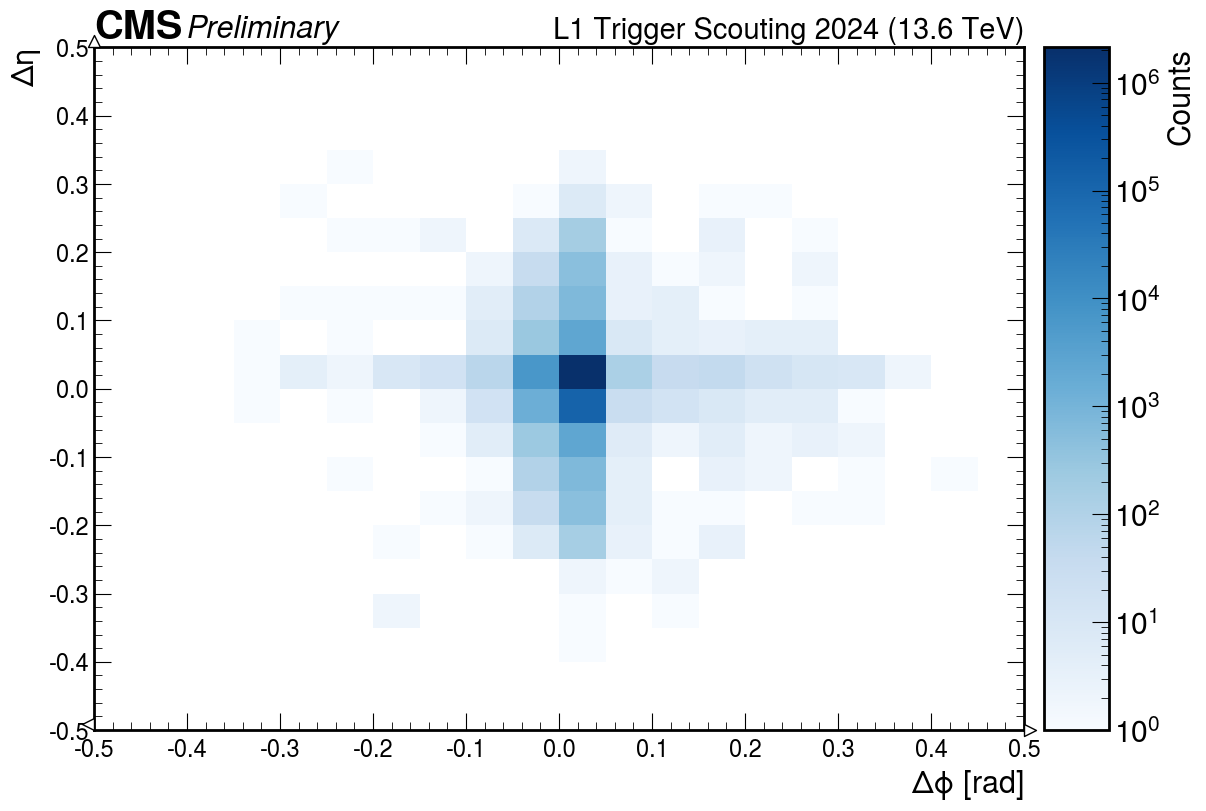

In [16]:
DeltaPhi_BMTF = MuonsProperties.DeltaPhiBMTF
DeltaEta_BMTF = MuonsProperties.DeltaEtaBMTF

a = 0.5
DeltaPhiRange = np.arange(-a, a, 0.05)
DeltaEtaRange = np.arange(-a, a, 0.05)

hist2d = hist.Hist(
    hist.axis.Variable(DeltaPhiRange, name='Phi'),
    hist.axis.Variable(DeltaEtaRange, name='Eta')

)
hist2d.fill(Phi=ak.flatten(DeltaPhi_BMTF), Eta=ak.flatten(DeltaEta_BMTF))


fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
draw_cms_label(ax, fontsize= FONTSIZE, rlabel="L1 Trigger Scouting 2024 (13.6 TeV)")

hep.hist2dplot(hist2d, cbar=True, cmap='Blues', ax=ax,  norm = LogNorm())

cbar = ax.collections[0].colorbar
cbar.set_label('Counts', fontsize=FONTSIZE)

ax.set_xlabel(r'$\Delta \phi$ [rad]')
ax.set_ylabel(r'$\Delta \eta$')
ax.grid(False)
ax.set_xticks(np.arange(-0.5, 0.6, 0.1))
ax.set_yticks(np.arange(-0.5, 0.6, 0.1))




ax.tick_params(axis='both', which='both', labelsize = FONTSIZE - 5)



'''plt.savefig("../Immagini/BMTFPhiEta.pdf")
plt.savefig("../Immagini/ImmaginiPNG/BMTFPhiEta.png")'''

plt.show()

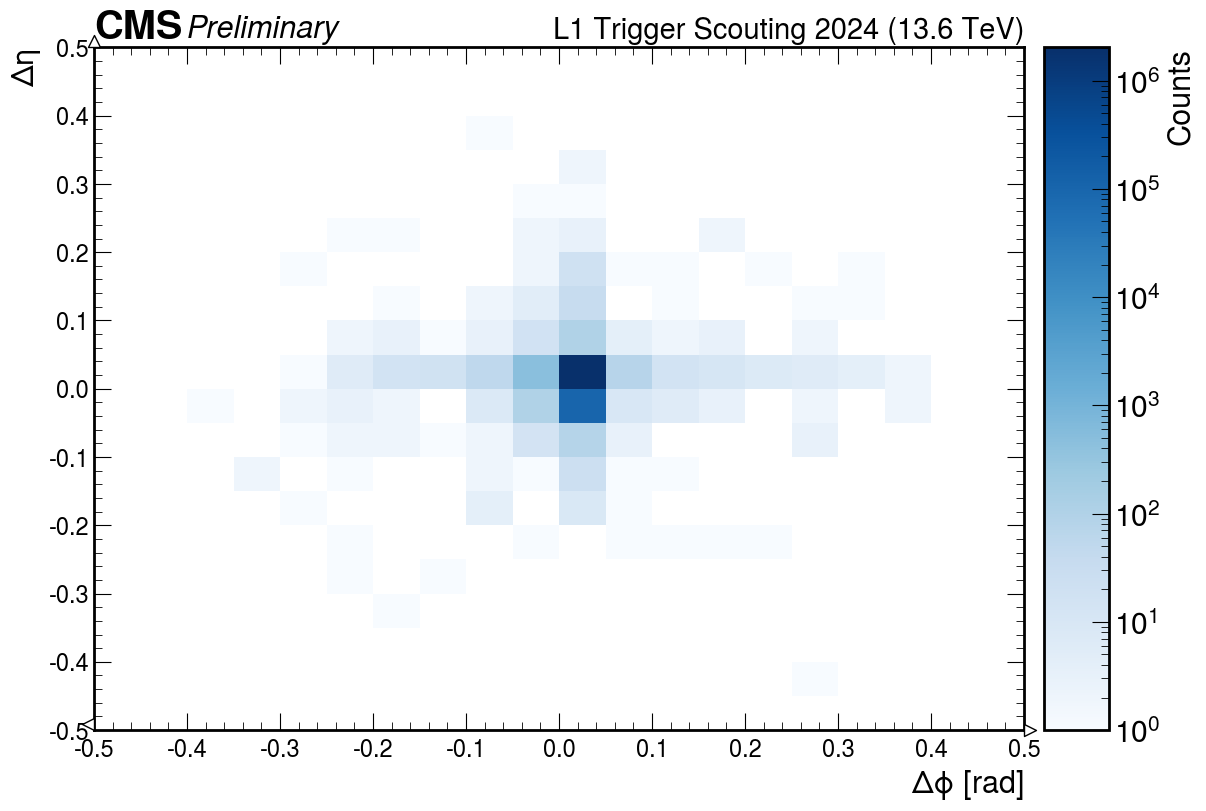

In [17]:
DeltaPhi_GMT = MuonsProperties.DeltaPhiGMT
DeltaEta_GMT = MuonsProperties.DeltaEtaGMT

a = 0.5
DeltaPhiRange = np.arange(-a, a, 0.05)
DeltaEtaRange = np.arange(-a, a, 0.05)

hist2d = hist.Hist(
    hist.axis.Variable(DeltaPhiRange, name='Phi'),
    hist.axis.Variable(DeltaEtaRange, name='Eta')

)
hist2d.fill(Phi=ak.flatten(DeltaPhi_GMT), Eta=ak.flatten(DeltaEta_GMT))


fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
draw_cms_label(ax, fontsize= FONTSIZE, rlabel="L1 Trigger Scouting 2024 (13.6 TeV)")

hep.hist2dplot(hist2d, cbar=True, cmap='Blues', ax=ax,  norm = LogNorm())

cbar = ax.collections[0].colorbar
cbar.set_label('Counts', fontsize=FONTSIZE)

ax.set_xlabel(r'$\Delta \phi$ [rad]')
ax.set_ylabel(r'$\Delta \eta$')
ax.grid(False)
ax.set_xticks(np.arange(-0.5, 0.6, 0.1))
ax.set_yticks(np.arange(-0.5, 0.6, 0.1))

ax.tick_params(axis='both', which='both', labelsize = FONTSIZE - 5)


'''plt.savefig("../Immagini/GMTPhiEta.pdf")
plt.savefig("../Immagini/ImmaginiPNG/GMTPhiEta.png")'''

plt.show()

# Matching Efficiency 

In [18]:
len(MuonsProperties.PtBMTF)

11604754

In [19]:
PtBMTF = ak.flatten(MuonsProperties.PtBMTF)
PtGMT = ak.flatten(MuonsProperties.PtGMT)

AllPtBMTF = ak.flatten(MuonsProperties.AllPtBMTF)
AllPtGMT = ak.flatten(MuonsProperties.AllPtGMT)

bins = np.array([0, 5, 10, 15, 20, 30, 40, 50, 100, 300])

centers = 0.5 * (bins[1:] + bins[:-1])
width = 0.5 * (bins[1:] - bins[:-1])

BMTFMatchingEfficiencyPt = np.zeros(len(bins))
GMTMatchingEfficiencyPt = np.zeros(len(bins))

PtBMTF_Hist = hist.Hist(hist.axis.Variable(bins, name="pTBMTF", label="BMTF Muon pT [GeV]"))
AllPtBMTF_Hist = hist.Hist(hist.axis.Variable(bins, name="AllpTBMTF", label="BMTF Muon pT [GeV]"))
PtGMT_Hist = hist.Hist(hist.axis.Variable(bins, name="pTGMT", label="GMT Muon pT [GeV]"))
AllPtGMT_Hist = hist.Hist(hist.axis.Variable(bins, name="AllpTGMT", label="GMT Muon pT [GeV]"))

PtBMTF_Hist.fill(pTBMTF=PtBMTF)
AllPtBMTF_Hist.fill(AllpTBMTF=AllPtBMTF)

for i in range(len(bins)-1):
 
  TempEff = PtBMTF_Hist[i] / AllPtBMTF_Hist[i]
  BMTFMatchingEfficiencyPt[i] = TempEff

PtGMT_Hist.fill(pTGMT=PtGMT)
AllPtGMT_Hist.fill(AllpTGMT=AllPtGMT)

for i in range(len(bins)-1):
 
  TempEff = PtGMT_Hist[i] / AllPtGMT_Hist[i]
  GMTMatchingEfficiencyPt[i] = TempEff

#print(BMTFMatchingEfficiencyPt[:-1])
#print(GMTMatchingEfficiencyPt[:-1])

print(PtBMTF_Hist)

                    ┌────────────────────────────────────────────────────────┐
[-inf,   0) 0       │                                                        │
[   0,   5) 1144882 │███████████████████████████████████████████████████████ │
[   5,  10) 825640  │███████████████████████████████████████▋                │
[  10,  15) 119435  │█████▊                                                  │
[  15,  20) 24994   │█▎                                                      │
[  20,  30) 11825   │▋                                                       │
[  30,  40) 3334    │▏                                                       │
[  40,  50) 1531    │▏                                                       │
[  50, 100) 2013    │▏                                                       │
[ 100, 300) 1445    │▏                                                       │
[ 300, inf) 0       │                                                        │
                    └───────────────────────────────

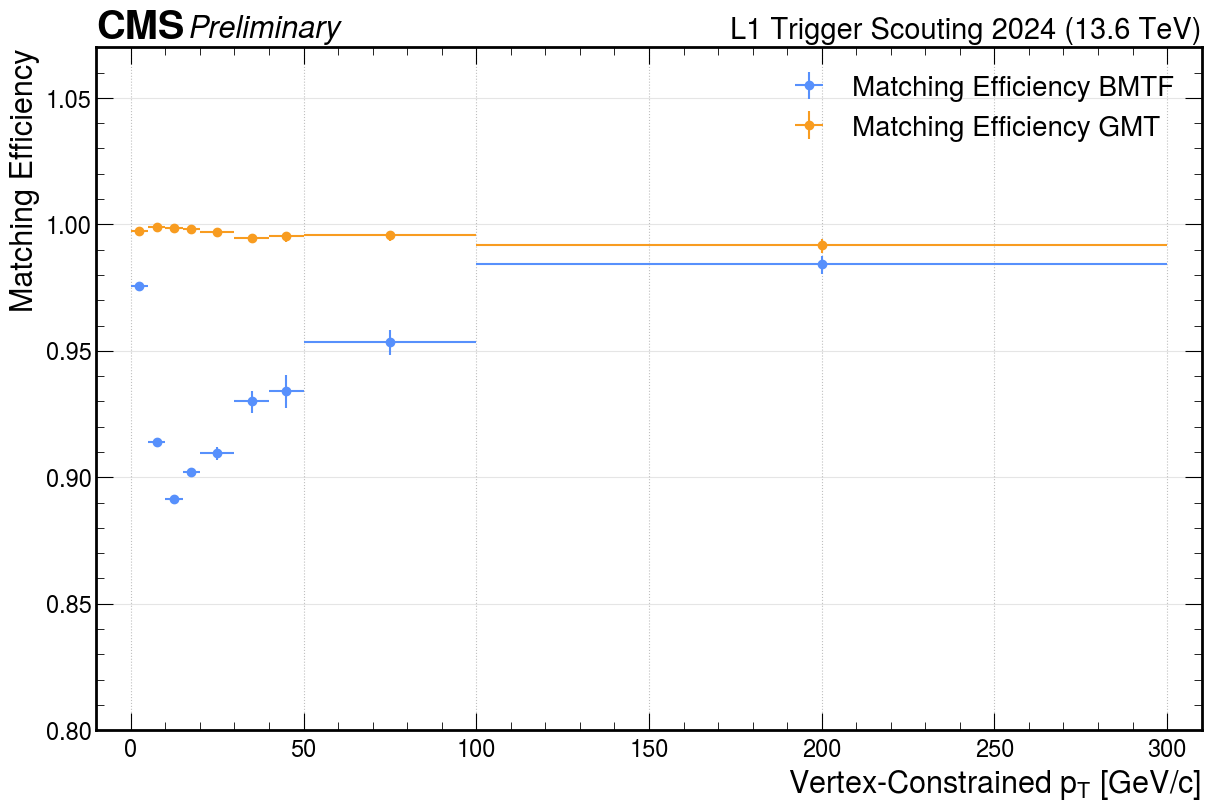

In [20]:
from hist import intervals
BMTFerror = hist.intervals.ratio_uncertainty(PtBMTF_Hist.values(), AllPtBMTF_Hist.values(), uncertainty_type = 'efficiency')
GMTerror = hist.intervals.ratio_uncertainty(PtGMT_Hist.values(), AllPtGMT_Hist.values(), uncertainty_type = 'efficiency')

fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
draw_cms_label(ax, fontsize= FONTSIZE, rlabel="L1 Trigger Scouting 2024 (13.6 TeV)")

ax.errorbar(centers, BMTFMatchingEfficiencyPt[:-1], xerr = width, yerr = BMTFerror, fmt = 'o', label="Matching Efficiency BMTF")
ax.errorbar(centers, GMTMatchingEfficiencyPt[:-1], xerr = width, yerr = GMTerror, fmt = 'o', label="Matching Efficiency GMT")

ax.set_ylim(0.8, 1.07)
ax.set_xlim(-10, 310)


ax.set_xlabel(r'Vertex-Constrained $p_T$ [GeV/c]')
ax.set_ylabel('Matching Efficiency')
ax.grid(True)
ax.legend(fontsize = 20)

ax.tick_params(axis='both', which='both', labelsize = FONTSIZE - 5)

plt.show()



# Check Quality

In [21]:
BMTFQuality = ak.concatenate([bmtf_awk_LS133.bmtfHwQual, bmtf_awk_LS263.bmtfHwQual, bmtf_awk_LS264.bmtfHwQual, bmtf_awk_LS306.bmtfHwQual])
QPtBMTF = MuonsProperties.PtBMTF
Unmatched_BMTF = MuonsProperties.unmatched_Bmtf_Events
'''
LowPt = []
Pt = []
HighPt = []

for i in tqdm.tqdm(range(1_000_000)):
  if len(QPtBMTF[i]) != 0:
    for j in range(len(QPtBMTF[i])):
      if len(QPtBMTF[i]) > len(BMTFQuality[i]):
        continue
      elif QPtBMTF[i, j] < 5.4:
        LowPt.append(BMTFQuality[i, j])
        Pt.append(QPtBMTF[i, j])

      elif QPtBMTF[i, j] > 99.5:
        HighPt.append(BMTFQuality[i, j])
        #print(BMTFQuality[i, j], QPtBMTF[i, j]'''

'\nfor i in tqdm.tqdm(range(1_000_000)):\n  if len(QPtBMTF[i]) != 0:\n    for j in range(len(QPtBMTF[i])):\n      if len(QPtBMTF[i]) > len(BMTFQuality[i]):\n        continue\n      elif QPtBMTF[i, j] < 5.4:\n        LowPt.append(BMTFQuality[i, j])\n        Pt.append(QPtBMTF[i, j])\n\n      elif QPtBMTF[i, j] > 99.5:\n        HighPt.append(BMTFQuality[i, j])\n        #print(BMTFQuality[i, j], QPtBMTF[i, j]'

In [22]:
#1235668
print(len(LowPt))
print(len(HighPt))


0
0


In [23]:
'''LowPt = ak.Array(LowPt)
HighPt = ak.Array(HighPt)

ak.to_parquet(LowPt, 'LowPt.parquet')
ak.to_parquet(HighPt, 'HighPt.parquet')'''

"LowPt = ak.Array(LowPt)\nHighPt = ak.Array(HighPt)\n\nak.to_parquet(LowPt, 'LowPt.parquet')\nak.to_parquet(HighPt, 'HighPt.parquet')"

In [32]:
binsQ = np.array([12, 13, 14, 15, 16])

LowPtQual_Hist = hist.Hist(hist.axis.Variable(binsQ, name="LowPtQual", ))
HighPtQual_Hist = hist.Hist(hist.axis.Variable(binsQ, name="HighPtQual",))

LowPtQual_Hist.fill(LowPtQual=LowPt)
HighPtQual_Hist.fill(HighPtQual=HighPt)

LowPtRatio_Qual = LowPtQual_Hist.values() / ak.sum(LowPtQual_Hist.values())
HighPtRatio_Qual = HighPtQual_Hist.values() / ak.sum(HighPtQual_Hist.values())

QualRatio = LowPtRatio_Qual / HighPtRatio_Qual

print(LowPtRatio_Qual)
print(HighPtRatio_Qual)
print(QualRatio)

bin_edges = LowPtQual_Hist.axes[0].edges
indices_in_bins = [(LowPt >= bin_edges[i]) & (LowPt < bin_edges[i + 1]) for i in range(len(bin_edges) - 1)]


[0.6379431  0.3468877  0.01429552 0.00087368]
[0.57796258 0.38115038 0.03257103 0.00831601]
[1.10377924 0.91010718 0.43890298 0.10506036]


Text(0, 1, 'Probability ratio')

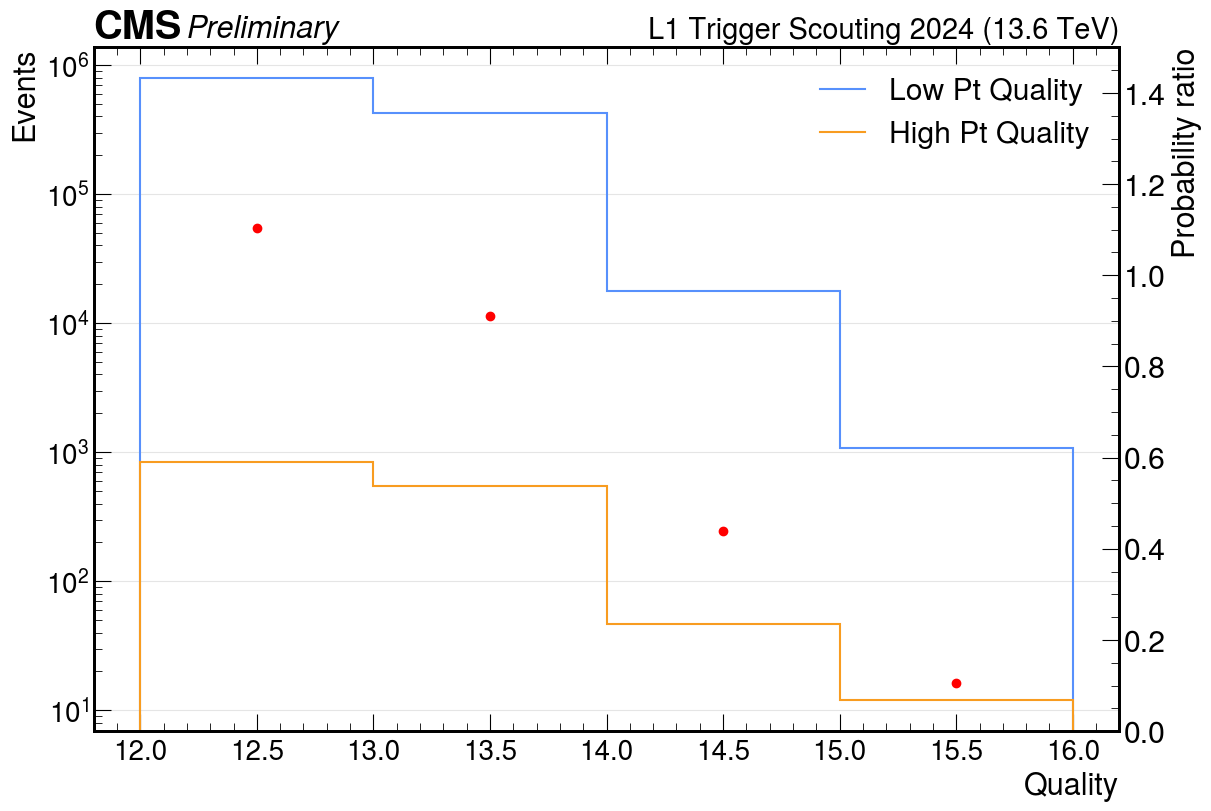

In [44]:
fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
draw_cms_label(ax, fontsize= FONTSIZE, rlabel="L1 Trigger Scouting 2024 (13.6 TeV)")

#ax.hist(PtBMTF_Hist.values(), bins=bins, label="BMTF")
#ax.hist(AllPtBMTF_Hist.values(), bins=bins, label="All BMTF")

hep.histplot(LowPtQual_Hist, label="Low Pt Quality", ax=ax, yerr = False)
hep.histplot(HighPtQual_Hist, label = "High Pt Quality", ax=ax, yerr = False)


ax.set_xlabel("Quality")
ax.set_ylabel("Events")
ax.legend()

ax.set_yscale('log')

ax2 = ax.twinx()

ax2.scatter([12.5, 13.5, 14.5, 15.5], QualRatio, label="Ratio", color="red")
ax2.set_ylim(0, 1.5)
ax2.set_ylabel("Probability ratio", fontsize = FONTSIZE)




Non è proprio come mi aspetto: sembra che a bassa qualità ci siano più eventi con pT basso, mentre ad alta qualità ci siano molti più eventi a pT alto

# Controllo dei possibili duplicati 

In [26]:


'''for i in range(100):
  print(i, DupPtGMT[i], GmtEta[i])'''

'for i in range(100):\n  print(i, DupPtGMT[i], GmtEta[i])'

In [27]:
DupPtGMT = MuonsProperties.PtGMT

EtaDup = []
PtDup = []

for i in tqdm.tqdm(range(len(DupPtGMT))):
  if len(DupPtGMT[i]) != 0:
    for j in range(len(DupPtGMT[i])):
      if DupPtGMT[i, j] > 99.5:
        EtaDup.append(GmtEta[i, j])
        PtDup.append(DupPtGMT[i, j])
        #print(BMTFQuality[i, j], DupPtGMT[i, j]'''

100%|██████████| 11604754/11604754 [06:45<00:00, 28650.64it/s]


In [28]:
EtaDup = ak.Array(EtaDup)
PtDup = ak.Array(PtDup)

ak.to_parquet(EtaDup, 'EtaDup.parquet')
ak.to_parquet(PtDup, 'PtDup.parquet')

  created_by: parquet-cpp-arrow version 14.0.2
  num_columns: 1
  num_rows: 1465
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 0

<>:22: SyntaxWarning: invalid escape sequence '\e'
<>:22: SyntaxWarning: invalid escape sequence '\e'
/var/folders/73/kb390p311j3ctnbn_v15y42w0000gn/T/ipykernel_65531/2245237926.py:22: SyntaxWarning: invalid escape sequence '\e'
  ax.set_xlabel("$\eta$")


'plt.savefig("../Immagini/BMTF_PtPtu.pdf")\nplt.savefig("../Immagini/ImmaginiPNG/BMTF_PtPtu.png")'

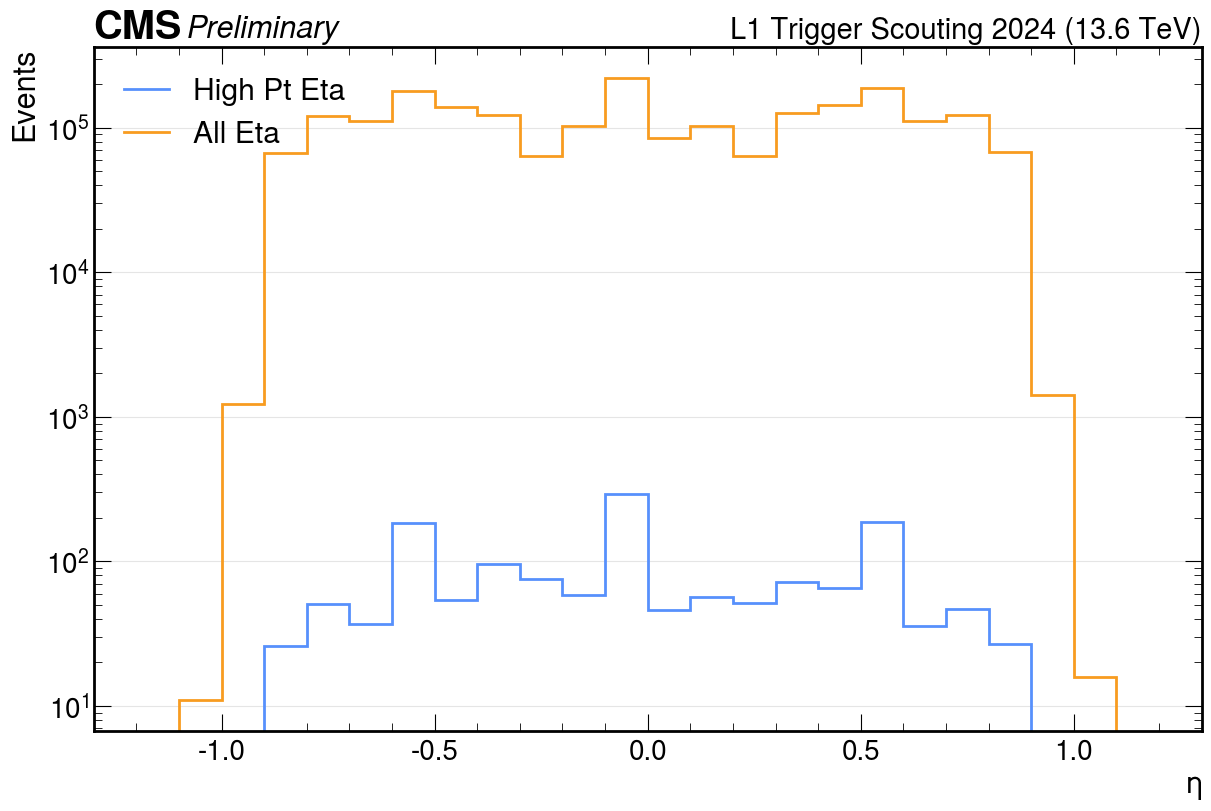

In [52]:
#GmtEta = ak.flatten(GmtEta)

binsDup = np.array(np.arange(-1.2, 1.2, 0.1))

EtaDup_Hist = hist.Hist(hist.axis.Variable(binsDup, name="Eta", ))
AllEta_Hist = hist.Hist(hist.axis.Variable(binsDup, name="AllEta", ))

EtaDup_Hist.fill(Eta=EtaDup)
AllEta_Hist.fill(AllEta=GmtEta)

fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
draw_cms_label(ax, fontsize= FONTSIZE, rlabel="L1 Trigger Scouting 2024 (13.6 TeV)")


hep.histplot(EtaDup_Hist, label = "High Pt Eta", ax=ax, yerr = False, lw = 2)
hep.histplot(AllEta_Hist, label = "All Eta", ax=ax, yerr = False, lw = 2)

ax.set_yscale('log')
ax.set_xlabel("$\eta$")
ax.set_ylabel("Events")
ax.set_xlim(-1.3, 1.3)

ax.legend(loc='upper left')

'''plt.savefig("../Immagini/BMTF_PtPtu.pdf")
plt.savefig("../Immagini/ImmaginiPNG/BMTF_PtPtu.png")'''

<>:24: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\e'
/var/folders/73/kb390p311j3ctnbn_v15y42w0000gn/T/ipykernel_65531/2496564637.py:24: SyntaxWarning: invalid escape sequence '\e'
  ax.set_ylabel("$\eta$")


Text(34.167000000000016, 1, '$\\eta$')

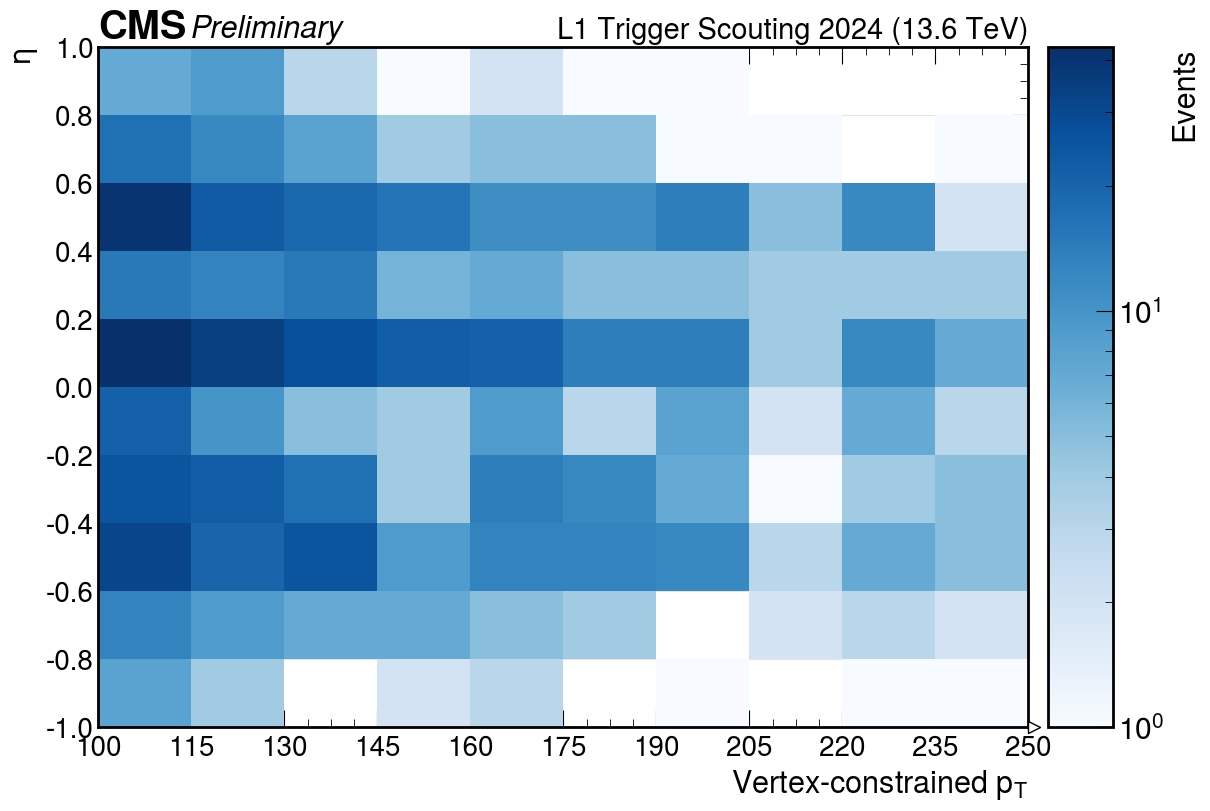

In [37]:
PtRange = np.arange(100, 265, 15)
EtaRange = np.arange(-1, 1.2, 0.2)

hist2d = hist.Hist(
    hist.axis.Variable(np.round(PtRange, 2), name='Pt', label='Pt number'),
    hist.axis.Variable(np.round(EtaRange, 2), name='Eta', label='Eta number'),
)

hist2d.fill(Pt=PtDup, Eta=EtaDup)

fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
draw_cms_label(ax, fontsize= FONTSIZE, rlabel="L1 Trigger Scouting 2024 (13.6 TeV)")

from matplotlib.colors import LogNorm

hep.hist2dplot(hist2d, cbar=True, cmap='Blues', ax=ax, norm = LogNorm())
cbar = ax.collections[0].colorbar
cbar.set_label('Events', fontsize=FONTSIZE)

ax.set_xlabel("Vertex-constrained $p_T$")
ax.set_ylabel("$\eta$")